# Basic Tutorial

### 1 Human preset
Start by loading the simplest preset, 1 human. To run a preset configuration:
1. Import the `AgentModel` class and the `load_data_file` helper function
2. Load the preset configuration by name - in this case, `config_1h.json`
3. Initialize the model using the `from_config` method, and use the double star operator to feel all keyward arguments from the configuration.
4. Run the simulation until termination using the `run` method
5. Export records from the simulation using the `get_records` method

In [1]:
import sys
sys.path.append('../..')

from simoc_abm import AgentModel, load_data_file

config = load_data_file('config_1h.json')
model = AgentModel.from_config(**config)
model.run()
data = model.get_records()

We now have a records object, which is a multi-level dict of all the relevant fields from the model. Let's take a quick look inside.

In [2]:
data.keys()

dict_keys(['time', 'step_num', 'agents'])

In [3]:
data['agents'].keys()

dict_keys(['human', 'solar_pv_array_mars', 'crew_habitat_small', 'ration_storage', 'water_storage', 'nutrient_storage', 'power_storage', 'solid_waste_aerobic_bioreactor', 'multifiltration_purifier_post_treatment', 'oxygen_generation_SFWE', 'urine_recycling_processor_VCD', 'co2_removal_SAWD', 'co2_makeup_valve', 'co2_storage', 'co2_reduction_sabatier', 'ch4_removal_agent', 'dehumidifier'])

In [4]:
data['agents']['human'].keys()

dict_keys(['active', 'cause_of_death', 'attributes', 'flows'])

SIMOC-ABM includes the helper function `plot_agent` to easily plot agent records using matplotlib. Let's take a look at human flows.

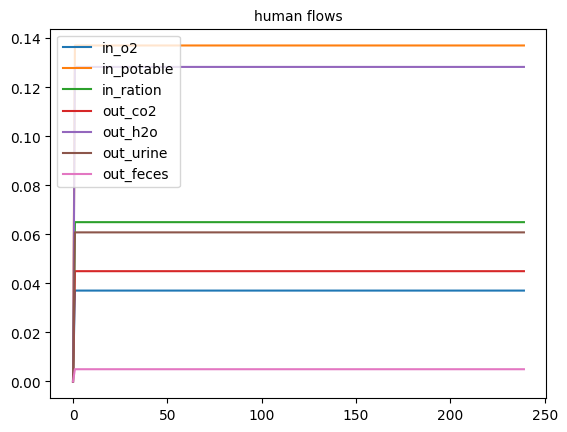

In [5]:
from simoc_abm.viz import plot_agent

plot_agent(data, 'human', 'flows');

The `plot_agent` function includes an `ax` kwarg, so we have the option of passing it an axis. The script below creates a 3-panel plot, and passes each panel to a different `plot_agent` function so we can view all three categories of human data side-by-side.

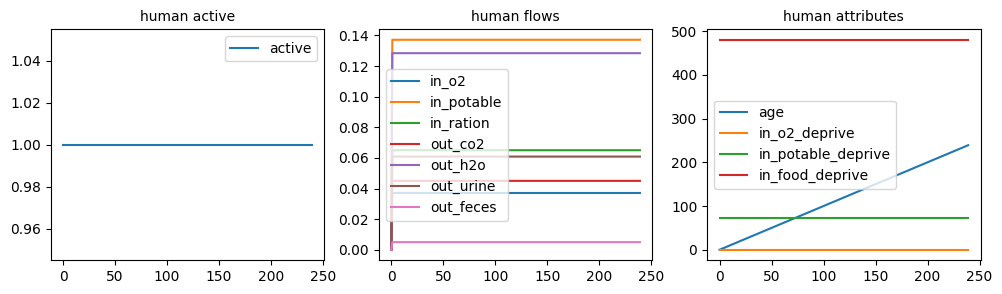

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plot_agent(data, 'human', 'active', ax=axs[0]);
plot_agent(data, 'human', 'flows', ax=axs[1]);
plot_agent(data, 'human', 'attributes', ax=axs[2]);

### 1 Human Radish
Next, let's look at a more complex agent. Load and run the 1 human + radish preset, and plot the `attributes` for the `radish` agent.

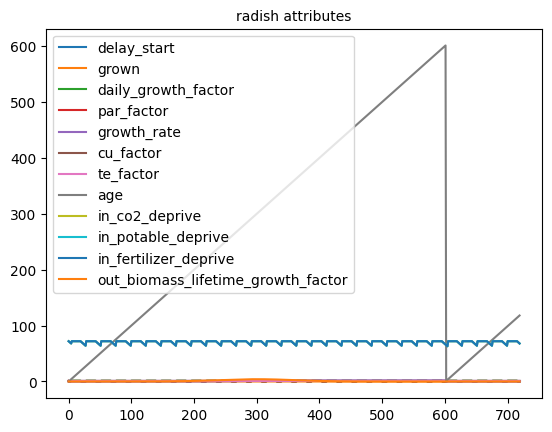

In [7]:
config = load_data_file('config_1hrad.json')
model = AgentModel.from_config(**config)
model.run()
data = model.get_records()
plot_agent(data, 'radish', 'attributes');

It's difficult to see too much from this plot because there are so many fields. We can narrow-down the fields using either the `exclude` or `include` kwargs. Let's remove the attributes with values outside the ~0-1 range: age and deprive.

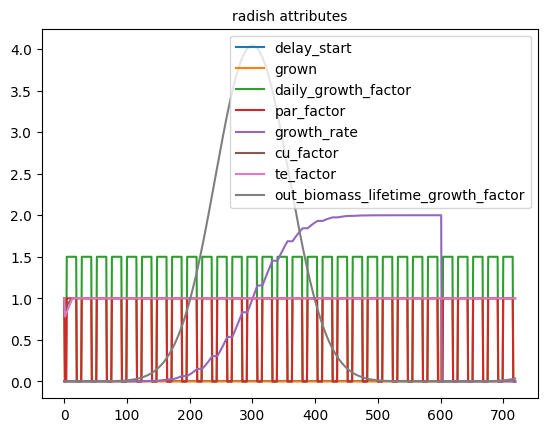

In [8]:
exclude = ['age', 'in_co2_deprive', 'in_potable_deprive', 'in_fertilizer_deprive']
plot_agent(data, 'radish', 'attributes', exclude=exclude);

Next, let's take a look at the CO2. Plot CO2 storage in the greenhouse and crew quarters side-by-side.

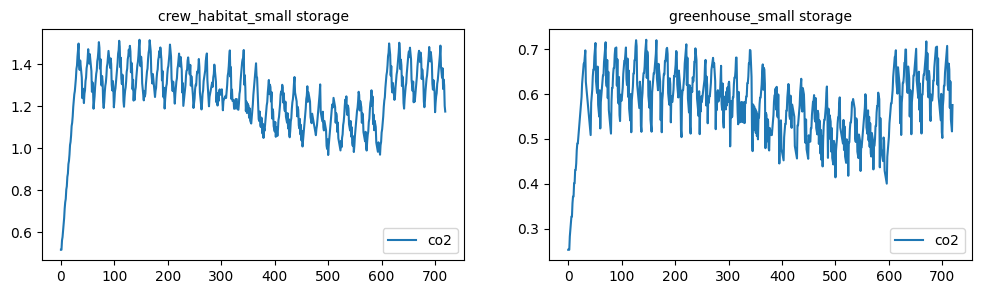

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
plot_agent(data, 'crew_habitat_small', 'storage', include=['co2'], ax=axs[0]);
plot_agent(data, 'greenhouse_small', 'storage', include=['co2'], ax=axs[1]);

You can see the behavior changes over time. If we check the radish charts above, it looks like the CO2 levels drop when the radish plant matures, and then go up again after it's harvested. Let's plot radish CO2 flows and the CO2 scrubber flows side-by-side to see how they line up with the levels in the atmosphere.

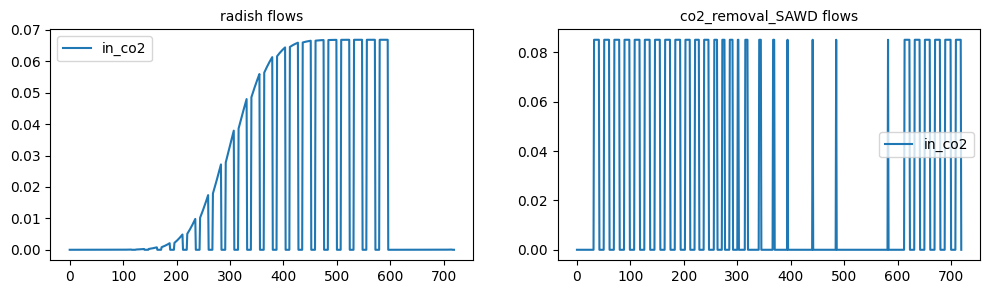

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
plot_agent(data, 'radish', 'flows', include=['co2'], ax=axs[0]);
plot_agent(data, 'co2_removal_SAWD', 'flows', include=['in_co2'], ax=axs[1]);

We can see that the CO2 scrubber actives less frequently when the radish is mature, because the radish is absorbing most of the CO2 created by the humans.

What would happen if we maintained a lower CO2 level? Let's try adjusting the activation point of the CO2 scrubber to a lower level. To see its current level, we can look at the 'flows' variable inside the CO2 scrubber agent:

In [11]:
co2_removal_SAWD = model.agents['co2_removal_SAWD']
co2_removal_SAWD.flows

{'in': {'co2': {'value': 0.085,
   'flow_rate': {'unit': 'kg', 'time': 'hour'},
   'criteria': [{'limit': '>',
     'value': 0.001,
     'buffer': 8,
     'path': 'in_co2_ratio'}],
   'connections': ['greenhouse_small', 'crew_habitat_small']},
  'kwh': {'value': 0.65,
   'requires': ['co2'],
   'flow_rate': {'unit': 'kWh', 'time': 'hour'},
   'connections': ['power_storage']}},
 'out': {'co2': {'value': 0.085,
   'requires': ['co2', 'kwh'],
   'flow_rate': {'unit': 'kg', 'time': 'hour'},
   'connections': ['co2_storage']}}}

Line 4, the in-flow co2 criteria value, is set to 0.001. We often discuss CO2 in terms of 'parts per million' or ppm, and this corresponds to 1000 ppm - a reasonable level for a greenhouse. Average levels for outdoor growing are closer to 450 parts per million.

Let's create a new model, but modify the configuration file to change the scrubber activation point to 450 ppm instead of 1000. First, load the preset again, and inspect the scrubber agent.

In [12]:
config2 = load_data_file('config_1hrad.json')
config2['agents']['co2_removal_SAWD']

{'amount': 1}

The only field we see is 'amount'. When using the `from_config` API, this dict will be merged with the default agent description. We can load the default agent and inspect it using the `get_default_agent_data` utility function.

In [13]:
from simoc_abm.util import get_default_agent_data
default_sawd = get_default_agent_data('co2_removal_SAWD')
default_sawd

{'amount': 1,
 'properties': {'mass': {'value': 137.35, 'unit': 'kg'},
  'volume': {'value': 0.31, 'unit': 'm^3'}},
 'flows': {'in': {'co2': {'value': 0.085,
    'flow_rate': {'unit': 'kg', 'time': 'hour'},
    'criteria': [{'limit': '>',
      'value': 0.001,
      'buffer': 8,
      'path': 'in_co2_ratio'}],
    'connections': ['greenhouse', 'habitat']},
   'kwh': {'value': 0.65,
    'requires': ['co2'],
    'flow_rate': {'unit': 'kWh', 'time': 'hour'},
    'connections': ['power_storage']}},
  'out': {'co2': {'value': 0.085,
    'requires': ['co2', 'kwh'],
    'flow_rate': {'unit': 'kg', 'time': 'hour'},
    'connections': ['co2_storage']}}},
 'description': 'Moves carbon dioxide from the habitat atmosphere to co2_storage.',
 'agent_class': 'eclss'}

To override default values, we can update the specific field we want, and include that in our configuration file.

In [14]:
default_sawd['flows']['in']['co2']['criteria'][0]['value'] = 0.00045
config2['agents']['co2_removal_SAWD'] = default_sawd

We can verify that it worked by instantiating a new model with our updated config, and inspecting the scrubber agent the same way:

In [15]:
model2 = AgentModel.from_config(**config2)
model2.agents['co2_removal_SAWD'].flows

{'in': {'co2': {'value': 0.085,
   'flow_rate': {'unit': 'kg', 'time': 'hour'},
   'criteria': [{'limit': '>',
     'value': 0.00045,
     'buffer': 8,
     'path': 'in_co2_ratio'}],
   'connections': ['crew_habitat_small', 'greenhouse_small']},
  'kwh': {'value': 0.65,
   'requires': ['co2'],
   'flow_rate': {'unit': 'kWh', 'time': 'hour'},
   'connections': ['power_storage']}},
 'out': {'co2': {'value': 0.085,
   'requires': ['co2', 'kwh'],
   'flow_rate': {'unit': 'kg', 'time': 'hour'},
   'connections': ['co2_storage']}}}

It worked! Let's run the model and plot the relevant agents.

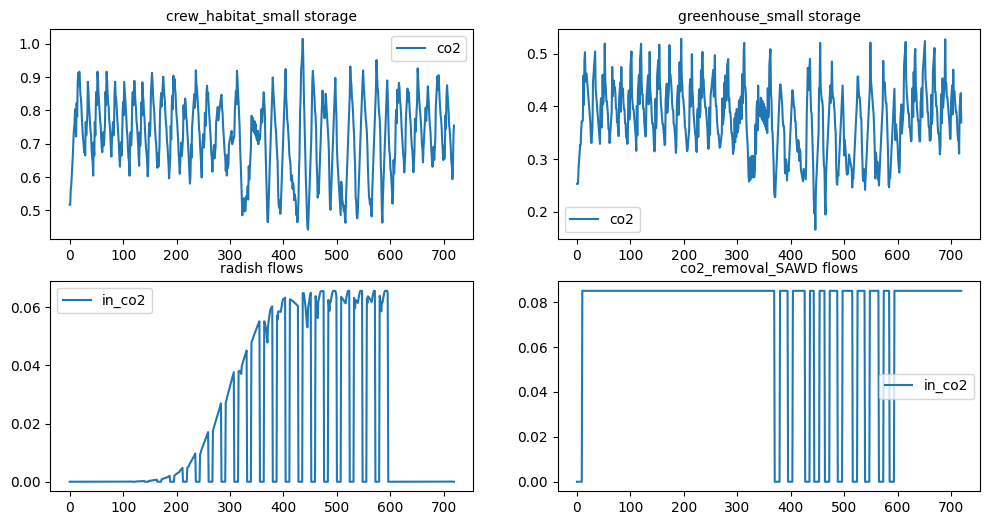

In [16]:
model2.run()
data2 = model2.get_records()

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
plot_agent(data2, 'crew_habitat_small', 'storage', include=['co2'], ax=axs[0][0]);
plot_agent(data2, 'greenhouse_small', 'storage', include=['co2'], ax=axs[0][1]);
plot_agent(data2, 'radish', 'flows', include=['in_co2'], ax=axs[1][0]);
plot_agent(data2, 'co2_removal_SAWD', 'flows', include=['in_co2'], ax=axs[1][1]);

We can see that CO2 levels in the habitat and storage are indeed lower and tje scrubber had to work a lot harder, but our radish CO2 consumption has also changed. Let's take a look at the radish attributes, specifically the growth factors, to idenfity what happened.

<module 'matplotlib.pyplot' from '/Users/granthawkins/simoc_lite/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

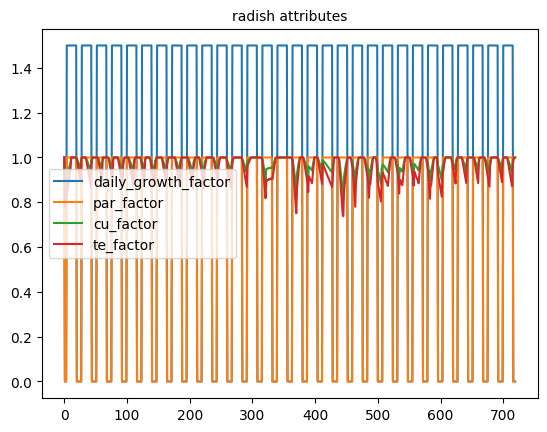

In [17]:
plot_agent(data2, 'radish', 'attributes', include=['cu_factor', 'te_factor', 'par_factor', 'daily_growth_factor'])

We can see that the `cu_factor` and `te_factor` often fall below 1. To try to figure out why, let's zoom in on a smaller date range, and line it up with the greenhouse co2 level. I'll focus on 4 days in the middle of the simulation by setting i=300 and j=396.

<Axes: title={'center': 'greenhouse_small storage'}>

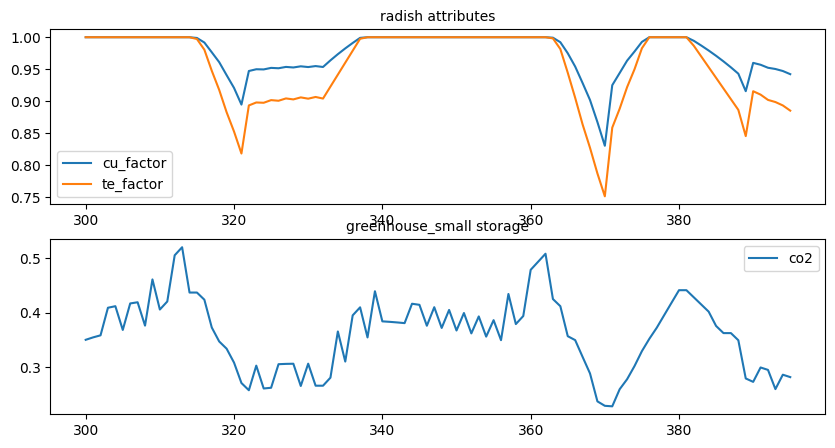

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
plot_agent(data2, 'radish', 'attributes', include=['te_factor', 'cu_factor'], i=300, j=396, ax=axs[0])
plot_agent(data2, 'greenhouse_small', 'storage', include=['co2'], i=300, j=396, ax=axs[1])

We can see clearly that, when ambient CO2 drops below some level (in the case of SIMOC, 700ppm), it negatively affects crop growth. Let's compare the internal biomass in the two scenarios to see the magnitude of the impact. We can plot both on one chart just by calling plot_agent twice. We should be able to guess which is which.

<module 'matplotlib.pyplot' from '/Users/granthawkins/simoc_lite/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

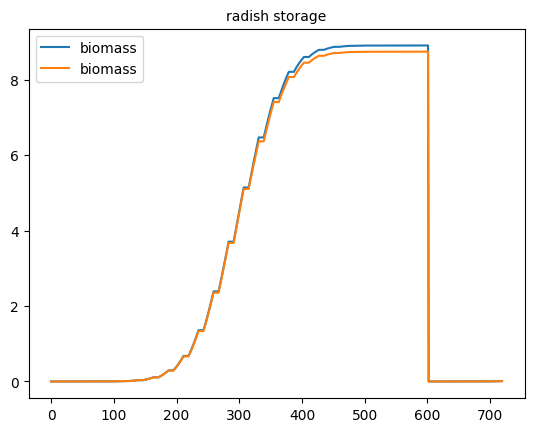

In [19]:
plot_agent(data, 'radish', 'storage')
plot_agent(data2, 'radish', 'storage')